In [1]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from torchsummary import summary
arch = 'resnet18'

# # load the pre-trained weights
# model_file = '%s_places365.pth.tar' % arch
# if not os.access(model_file, os.W_OK):
#     weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
#     print(weight_url)
#     os.system('wget ' + weight_url)
model_file="/content/drive/MyDrive/DeepLearning/SceneClassification/resnet18_places365.pth.tar"
model = models.__dict__["resnet18"](num_classes=365)
# summary(model,(3,277,277))
checkpoint = torch.load(model_file,map_location=lambda storage, loc: storage)
# print(checkpoint['state_dict'].items())
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
# print(state_dict.items())
model.load_state_dict(state_dict,strict=False)
model.eval()
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
     synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
     os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
         classes.append(line.strip().split(' ')[0][3:])
# import inspect

# print(dir(model))
# print(inspect.getsource(model))
# # logit = model.forward(input_img)
# h_x = F.softmax(logit, 1).data.squeeze()

In [5]:
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
!unzip  /content/drive/MyDrive/DeepLearning/SceneClassification/IndoorData.zip



Archive:  /content/drive/MyDrive/DeepLearning/SceneClassification/IndoorData.zip
   creating: IndoorData/bathroom/
  inflating: IndoorData/bathroom/008.jpg  
  inflating: IndoorData/bathroom/100_0281.jpg  
  inflating: IndoorData/bathroom/100_1412.jpg  
  inflating: IndoorData/bathroom/14_master_bathroom_jl.jpg  
  inflating: IndoorData/bathroom/b1.jpg  
  inflating: IndoorData/bathroom/b10.jpg  
  inflating: IndoorData/bathroom/b11.jpg  
  inflating: IndoorData/bathroom/b12.jpg  
  inflating: IndoorData/bathroom/b2.jpg  
  inflating: IndoorData/bathroom/b3.jpg  
  inflating: IndoorData/bathroom/b4.jpg  
  inflating: IndoorData/bathroom/b5.jpg  
  inflating: IndoorData/bathroom/b6.jpg  
  inflating: IndoorData/bathroom/b7.jpg  
  inflating: IndoorData/bathroom/b8.jpg  
  inflating: IndoorData/bathroom/b9.jpg  
  inflating: IndoorData/bathroom/bano3_2.jpg  
  inflating: IndoorData/bathroom/bath.jpg  
  inflating: IndoorData/bathroom/bath166.jpg  
  inflating: IndoorData/bathroom/bath17.

In [7]:
import torch.nn as nn
num_ftrs = model.fc.in_features
# model.fc1=torch.nn.Linear(365,11)
model.fc=nn.Linear(num_ftrs,11)
# model = nn.Sequential(
#     model,
#     nn.Linear(365,11))

In [8]:
# summary(model,(3,224,224))
# for para, name in model.named_parameters():
#   print(para)
for param in model.parameters():
      param.requires_grad = False
for param in model.fc.parameters():
      param.requires_grad = True
# summary(model,(3,224,224))


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import glob
import torchvision
import numpy as np
#Data Uploading Class
class MyDataset(Dataset):

    def __init__(self, dataset_path, transform = None):
        super().__init__()
        self.transform = transform
        self.class_paths = glob.glob(dataset_path+'/*')

        self.class_labels={}
        self.file_paths = []
        self.labels = []
        self.len = 0

        for i in range(len(self.class_paths)):
            self.file_paths += glob.glob(self.class_paths[i]+'/*')
            self.labels += len(glob.glob(self.class_paths[i]+'/*'))*[i]
            self.class_labels[i] = self.class_paths[i].split('/')[-1]

    def __len__(self):
        self.len = len(self.file_paths)
        
        return self.len

    def __getitem__(self, index):

        img = Image.open(self.file_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)

        label = self.labels[index]
        # yoloObjects=YoloOutput(self.file_paths[index])

        return img, label

In [10]:
Dataset=MyDataset( dataset_path="/content/IndoorData", transform = centre_crop)
train_set, val_set = torch.utils.data.random_split(Dataset, [0.8,0.2])
print(len(val_set))
# print(traindata.class_labels)
# print(len(traindata.labels))
# # valdata=MyDataset( dataset_path="/content/indoorCVPR_09/Images", transform = centre_crop)
# # print(len(valdata))
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=64)
test_dataloader = DataLoader(val_set, shuffle=True, batch_size=64)

724


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()
def train():
    model.train()   
    loss=0
    running_loss = 0.0
    train_acc=0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _,predict=torch.max(outputs,1)
        train_acc+=(predict == labels).sum().item()
        running_loss += loss.item()
    return train_acc/len(train_set),running_loss/len(train_dataloader)

def test(): 
    model.eval()   
    loss=0
    running_loss = 0.0
    test_acc=0
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _,predict=torch.max(outputs,1)
        test_acc+=(predict == labels).sum().item()
        running_loss += loss.item()
    return test_acc/len(val_set),running_loss/len(test_dataloader)

print("Model Training")
TrainAcc=[0]
TestAcc=[0]
TrainLoss=[0]
TestLOSS=[0]
for epoch in range(10):
  train_acc,train_los=train()
  test_acc,test_los=test()
  TrainAcc.append(train_acc*100)
  TestAcc.append(test_acc*100)
  TrainLoss.append(train_los)
  TestLOSS.append(test_los)
  print(f'Epoch: {epoch + 1} Training loss: {train_los:.3f} Testing loss: {test_los:.3f} Train Accracy: {train_acc*100:.3f}% Test Accracy: {test_acc*100:.3f}%')
  # writer.add_scalar("Loss/test", test_los, epoch+1)
  # writer.add_scalar("accuracy/test", test_acc*100, epoch+1)
  # writer.add_scalar("Loss/train", train_los, epoch+1)
  # writer.add_scalar("accuracy/train",train_acc*100, epoch+1)
  # writer.add_scalars('ModelAccuracy', {'train': train_acc*100,'test': test_acc}, epoch+1)
  # writer.add_scalars('ModelLoss', {'train': train_los,'test': test_los}, epoch+1)


# writer.flush()
# print("Model Trained")

# %load_ext tensorboard
# %tensorboard --logdir ./logs/func

Model Training
Epoch: 1 Training loss: 1.984 Testing loss: 1.535 Train Accracy: 35.483% Test Accracy: 58.287%
Epoch: 2 Training loss: 1.364 Testing loss: 1.125 Train Accracy: 62.241% Test Accracy: 70.580%
Epoch: 3 Training loss: 1.108 Testing loss: 0.931 Train Accracy: 68.552% Test Accracy: 74.171%
Epoch: 4 Training loss: 0.950 Testing loss: 0.820 Train Accracy: 73.828% Test Accracy: 77.762%
Epoch: 5 Training loss: 0.861 Testing loss: 0.744 Train Accracy: 76.517% Test Accracy: 79.144%
Epoch: 6 Training loss: 0.789 Testing loss: 0.722 Train Accracy: 77.931% Test Accracy: 80.387%
Epoch: 7 Training loss: 0.754 Testing loss: 0.644 Train Accracy: 78.414% Test Accracy: 81.077%
Epoch: 8 Training loss: 0.722 Testing loss: 0.629 Train Accracy: 79.345% Test Accracy: 82.044%
Epoch: 9 Training loss: 0.687 Testing loss: 0.603 Train Accracy: 80.207% Test Accracy: 82.320%
Epoch: 10 Training loss: 0.660 Testing loss: 0.583 Train Accracy: 81.448% Test Accracy: 83.564%


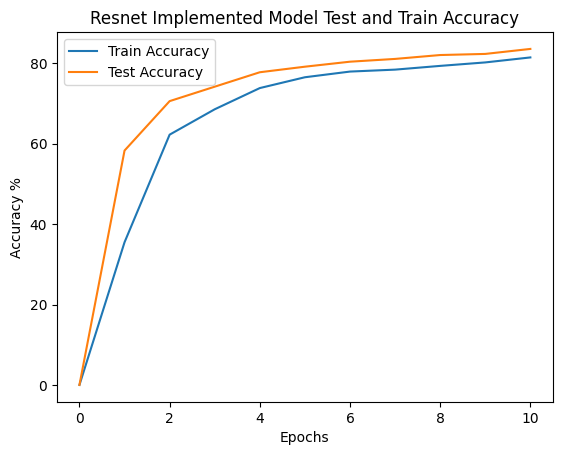

In [13]:
import matplotlib.pyplot as plt


# Create a figure and axis
# fig, ax = plt.subplots()

# Create the plot
plt.plot(TrainAcc)
plt.plot(TestAcc)

# Set the x and y labels
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
# Set the title
plt.title("Resnet Implemented Model Test and Train Accuracy")
plt.legend(['Train Accuracy', 'Test Accuracy'])

# Show the plot
plt.show()

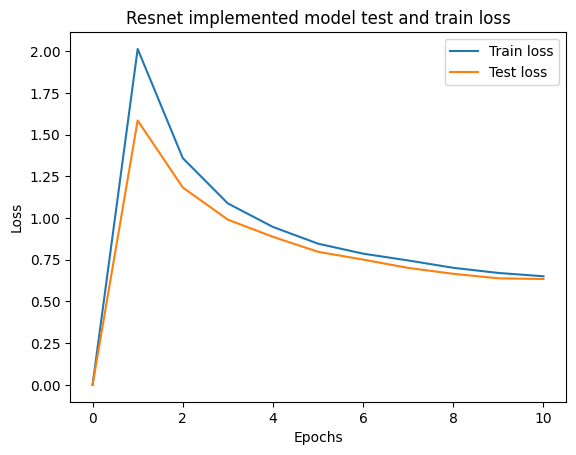

In [ ]:

plt.plot(TrainLoss)
plt.plot(TestLOSS)

# Set the x and y labels
plt.xlabel("Epochs")
plt.ylabel("Loss")
# Set the title
plt.title("Resnet implemented model test and train loss")
plt.legend(['Train loss', 'Test loss'])

# Show the plot
plt.show()

In [ ]:
# CSV file Generation
import csv
with open("SceneClassificationDatasetUpdated.csv", "w") as f:
  for i, data in enumerate(train_dataloader, 0):
    ima,label,yol,Uselesslabelss=data
    Resenet=model.forward(ima)
    h_x = F.softmax(Resenet, 1).data.squeeze()
    batchData=torch.cat((h_x, yol,label.reshape(len(label),1)), 1)
    writer = csv.writer(f)
    writer.writerows(batchData.detach().numpy())
